Dataset loaded.
Shape (rows, columns): (32833, 23)

First 5 rows:
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_alb

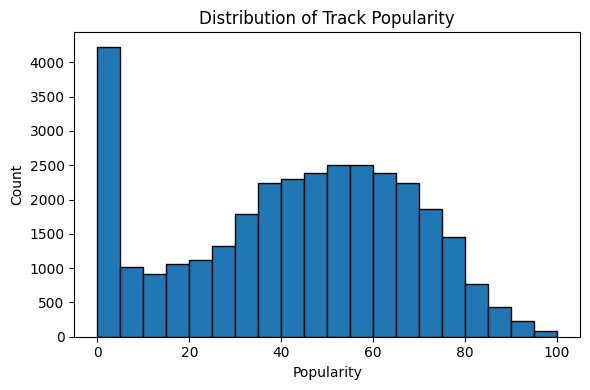

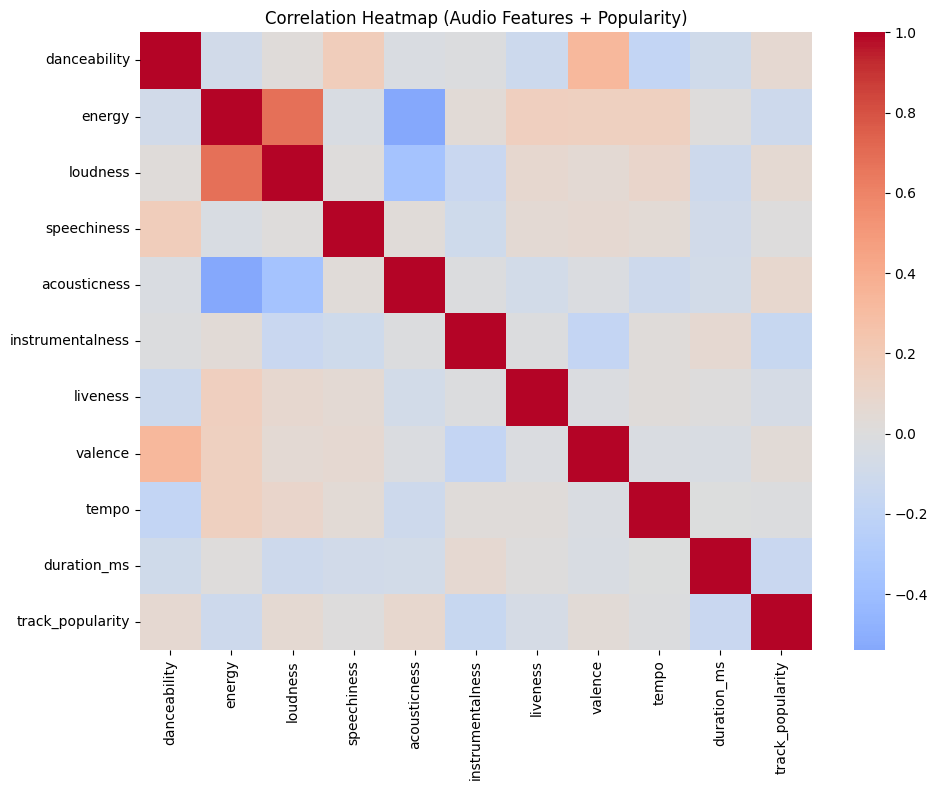

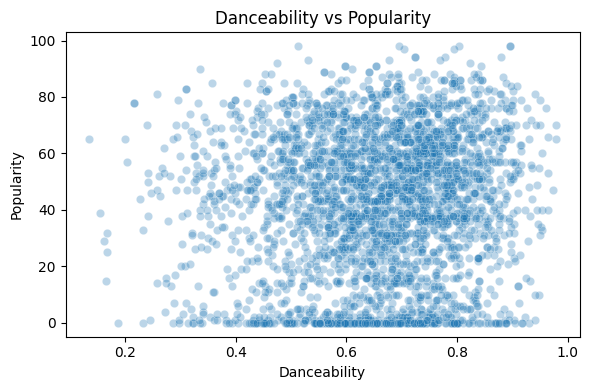

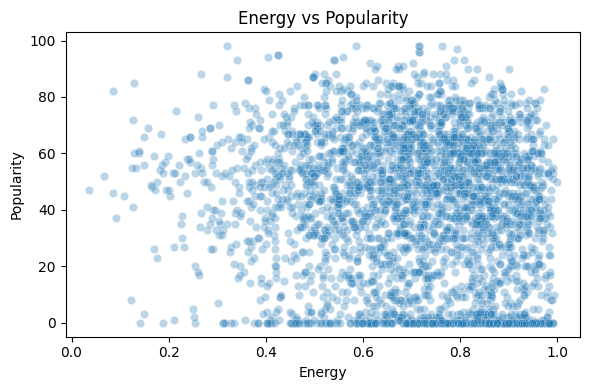

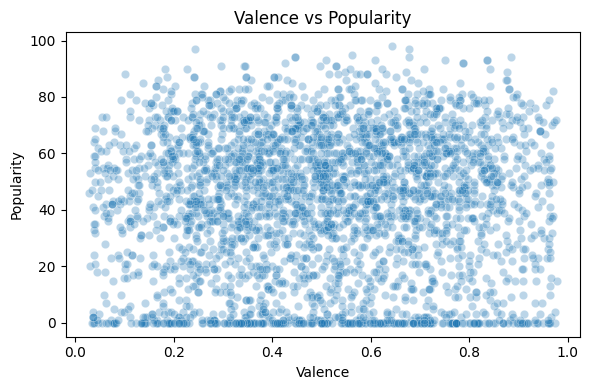

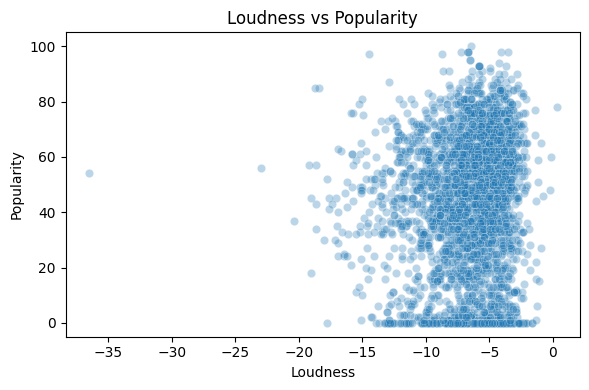


================ HYPOTHESIS TESTING ================

Correlation between danceability and popularity:
  Pearson r = 0.065, p-value = 7.575e-32
  Spearman r = 0.065, p-value = 2.560e-32

Correlation between energy and popularity:
  Pearson r = -0.109, p-value = 1.662e-87
  Spearman r = -0.118, p-value = 5.772e-103

T-test: Popularity of high vs low danceability songs
  Mean popularity (low danceability):  40.87
  Mean popularity (high danceability): 44.86
  t-statistic = 10.211, p-value = 2.085e-24

ANOVA: Popularity across low / medium / high valence groups
  Mean popularity (low valence):    40.50
  Mean popularity (medium valence): 43.37
  Mean popularity (high valence):   42.76
  F-statistic = 35.758, p-value = 3.072e-16

Train set size: (26266, 10)
Test set size : (6567, 10)

===== BASELINE MODEL (Predict Mean Popularity) =====
Baseline MAE  : 20.877
Baseline RMSE : 24.921

===== RANDOM FOREST MODEL PERFORMANCE (Test Set) =====
MAE  : 16.326
RMSE : 20.827
R^2  : 0.301

Comparison

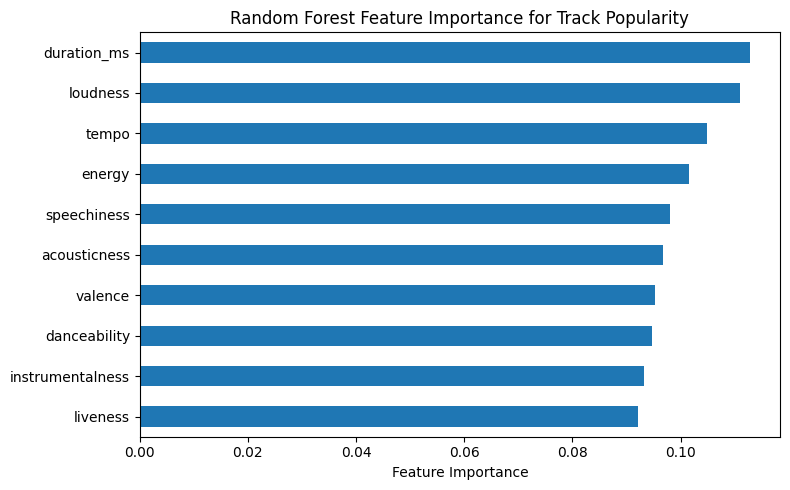


Sample of actual vs predicted popularity (first 20 test songs):
    actual_popularity  predicted_popularity
0                  45             41.153095
1                  17             22.276667
2                  30             42.775111
3                  35             37.566667
4                  62             32.717167
5                  22             45.190222
6                  33             35.753750
7                  78             67.044444
8                  44             46.138333
9                  50             45.872667
10                 69             29.206111
11                 31             38.383611
12                 54             36.540000
13                 67             64.303333
14                 65             58.424074
15                 14             52.926667
16                 42             46.210000
17                 46             40.901111
18                 37             37.030000
19                 46             31.097778


In [ ]:
# ==========================================================
# SPOTIFY POPULARITY PROJECT
# - Data exploration & visualization
# - Hypothesis testing
# - Popularity prediction with Random Forest
# ==========================================================

# ---------------- 1. IMPORT LIBRARIES ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway

pd.set_option("display.max_columns", None)

# ---------------- 2. LOAD DATA ----------------
# Make sure 'spotify_songs.csv' is in the same directory.
df = pd.read_csv("spotify_songs.csv")

print("Dataset loaded.")
print("Shape (rows, columns):", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# ---------------- 3. BASIC INFO & MISSING VALUES ----------------
print("\nData types and non-null counts:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

# ---------------- 4. BASIC CLEANING ----------------
# 4.1 Drop duplicates
df = df.drop_duplicates()
print("\nShape after dropping duplicates:", df.shape)

# 4.2 Define target column (adjust name if needed)
target_col = "track_popularity"
if target_col not in df.columns:
    raise ValueError(f"Column '{target_col}' not found. Check your CSV column names.")

# Drop rows where popularity is missing
if df[target_col].isnull().sum() > 0:
    df = df.dropna(subset=[target_col])
    print("Dropped rows with missing popularity. New shape:", df.shape)

# ---------------- 5. SELECT AUDIO FEATURES ----------------
audio_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms"
]

# Check which of these exist in the dataset
missing_feats = [col for col in audio_features if col not in df.columns]
if missing_feats:
    print("\nWARNING: These features were not found in the dataset and will be removed from the model:")
    print(missing_feats)
    audio_features = [col for col in audio_features if col in df.columns]

print("\nUsing these feature columns:")
print(audio_features)

# Drop rows with any missing values in selected features or target
df_model = df.dropna(subset=audio_features + [target_col])
print("\nShape after dropping rows with missing features/target:", df_model.shape)

print("\nDescriptive statistics for features + target:")
print(df_model[audio_features + [target_col]].describe())

# ==========================================================
# PART A: DATA VISUALIZATION
# ==========================================================

# ---------- A1. Distribution of Popularity ----------
plt.figure(figsize=(6, 4))
plt.hist(df_model[target_col], bins=20, edgecolor="black")
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- A2. Correlation Heatmap ----------
plt.figure(figsize=(10, 8))
corr = df_model[audio_features + [target_col]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Audio Features + Popularity)")
plt.tight_layout()
plt.show()

# ---------- A3. Scatter Plots: Top Features vs Popularity ----------
# We'll plot a few key features vs popularity (if they exist)
scatter_feats = [f for f in ["danceability", "energy", "valence", "loudness"] if f in audio_features]

for feat in scatter_feats:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_model.sample(min(3000, len(df_model))), x=feat, y=target_col, alpha=0.3)
    plt.title(f"{feat.capitalize()} vs Popularity")
    plt.xlabel(feat.capitalize())
    plt.ylabel("Popularity")
    plt.tight_layout()
    plt.show()

# ==========================================================
# PART B: HYPOTHESIS TESTING
# ==========================================================
# We will test a few simple hypotheses:

# H1: Songs with higher danceability have higher popularity.
# H2: Songs with higher energy have higher popularity.
# H3: Songs with "medium" valence have different popularity than low/high valence.

print("\n================ HYPOTHESIS TESTING ================")

# ---------- B1. Correlation Tests (Danceability & Energy vs Popularity) ----------
for feat in ["danceability", "energy"]:
    if feat in audio_features:
        # Pearson correlation (linear relationship)
        pearson_r, pearson_p = pearsonr(df_model[feat], df_model[target_col])
        # Spearman correlation (monotonic relationship, more robust)
        spearman_r, spearman_p = spearmanr(df_model[feat], df_model[target_col])

        print(f"\nCorrelation between {feat} and popularity:")
        print(f"  Pearson r = {pearson_r:.3f}, p-value = {pearson_p:.3e}")
        print(f"  Spearman r = {spearman_r:.3f}, p-value = {spearman_p:.3e}")
    else:
        print(f"\n{feat} not available, skipping correlation test.")

# ---------- B2. T-test: Top 25% vs Bottom 25% Danceability ----------
if "danceability" in audio_features:
    q25 = df_model["danceability"].quantile(0.25)
    q75 = df_model["danceability"].quantile(0.75)

    low_d = df_model[df_model["danceability"] <= q25][target_col]
    high_d = df_model[df_model["danceability"] >= q75][target_col]

    t_stat, p_val = ttest_ind(high_d, low_d, equal_var=False)

    print("\nT-test: Popularity of high vs low danceability songs")
    print(f"  Mean popularity (low danceability):  {low_d.mean():.2f}")
    print(f"  Mean popularity (high danceability): {high_d.mean():.2f}")
    print(f"  t-statistic = {t_stat:.3f}, p-value = {p_val:.3e}")
else:
    print("\nDanceability not available, skipping t-test.")

# ---------- B3. ANOVA: Popularity across low / medium / high valence ----------
if "valence" in audio_features:
    # Define bins for valence
    valence_low = df_model[df_model["valence"] < 0.33][target_col]
    valence_mid = df_model[(df_model["valence"] >= 0.33) & (df_model["valence"] <= 0.66)][target_col]
    valence_high = df_model[df_model["valence"] > 0.66][target_col]

    f_stat, p_val = f_oneway(valence_low, valence_mid, valence_high)

    print("\nANOVA: Popularity across low / medium / high valence groups")
    print(f"  Mean popularity (low valence):    {valence_low.mean():.2f}")
    print(f"  Mean popularity (medium valence): {valence_mid.mean():.2f}")
    print(f"  Mean popularity (high valence):   {valence_high.mean():.2f}")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_val:.3e}")
else:
    print("\nValence not available, skipping ANOVA test.")

# ==========================================================
# PART C: MODELING – RANDOM FOREST FOR POPULARITY
# ==========================================================

# ---------- C1. Train-Test Split ----------
X = df_model[audio_features]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain set size:", X_train.shape)
print("Test set size :", X_test.shape)

# ---------- C2. Baseline Model ----------
# Always predict the mean popularity of the training set
baseline_pred = np.full(shape=len(y_test), fill_value=y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("\n===== BASELINE MODEL (Predict Mean Popularity) =====")
print(f"Baseline MAE  : {baseline_mae:.3f}")
print(f"Baseline RMSE : {baseline_rmse:.3f}")

# ---------- C3. Random Forest Regressor ----------
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# ---------- C4. Evaluation ----------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n===== RANDOM FOREST MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R^2  : {r2:.3f}")

print("\nComparison to Baseline (lower MAE/RMSE is better):")
print(f"Baseline MAE  : {baseline_mae:.3f}")
print(f"RandomForest MAE  : {mae:.3f}")
print(f"Baseline RMSE : {baseline_rmse:.3f}")
print(f"RandomForest RMSE : {rmse:.3f}")

# ---------- C5. Feature Importance ----------
importances = rf_model.feature_importances_
feat_imp_series = pd.Series(importances, index=audio_features).sort_values(ascending=True)

print("\nFeature importances (higher = more important):")
print(feat_imp_series.sort_values(ascending=False))

plt.figure(figsize=(8, 5))
feat_imp_series.plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance for Track Popularity")
plt.tight_layout()
plt.show()

# ---------- C6. Sample Predictions ----------
results_sample = pd.DataFrame({
    "actual_popularity": y_test.values[:20],
    "predicted_popularity": y_pred[:20]
})

print("\nSample of actual vs predicted popularity (first 20 test songs):")
print(results_sample)

# ==========================================================
# END OF SCRIPT
# ==========================================================


In [ ]:
# ==========================================================
# SPOTIFY POPULARITY PROJECT
# - Data exploration & visualization
# - Hypothesis testing
# - Popularity prediction with multiple models
# ==========================================================

# ---------------- 1. IMPORT LIBRARIES ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor  # pip install xgboost if needed

from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway

pd.set_option("display.max_columns", None)

# ---------------- 2. LOAD DATA ----------------
# Make sure 'spotify_songs.csv' is in the same directory.
df = pd.read_csv("spotify_songs.csv")

print("Dataset loaded.")
print("Shape (rows, columns):", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# ---------------- 3. BASIC INFO & MISSING VALUES ----------------
print("\nData types and non-null counts:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

# ---------------- 4. BASIC CLEANING ----------------
# 4.1 Drop duplicates
df = df.drop_duplicates()
print("\nShape after dropping duplicates:", df.shape)

# 4.2 Define target column (adjust name if needed)
target_col = "track_popularity"
if target_col not in df.columns:
    raise ValueError(f"Column '{target_col}' not found. Check your CSV column names.")

# Drop rows where popularity is missing
if df[target_col].isnull().sum() > 0:
    df = df.dropna(subset=[target_col])
    print("Dropped rows with missing popularity. New shape:", df.shape)

# ---------------- 5. SELECT AUDIO FEATURES ----------------
audio_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms"
]

# Check which of these exist in the dataset
missing_feats = [col for col in audio_features if col not in df.columns]
if missing_feats:
    print("\nWARNING: These features were not found in the dataset and will be removed from the model:")
    print(missing_feats)
    audio_features = [col for col in audio_features if col in df.columns]

print("\nUsing these feature columns:")
print(audio_features)

# Drop rows with any missing values in selected features or target
df_model = df.dropna(subset=audio_features + [target_col])
print("\nShape after dropping rows with missing features/target:", df_model.shape)

print("\nDescriptive statistics for features + target:")
print(df_model[audio_features + [target_col]].describe())

# ==========================================================
# PART A: DATA VISUALIZATION
# ==========================================================

# ---------- A1. Distribution of Popularity ----------
plt.figure(figsize=(6, 4))
plt.hist(df_model[target_col], bins=20, edgecolor="black")
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- A2. Correlation Heatmap ----------
plt.figure(figsize=(10, 8))
corr = df_model[audio_features + [target_col]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Audio Features + Popularity)")
plt.tight_layout()
plt.show()

# ---------- A3. Scatter Plots: Selected Features vs Popularity ----------
scatter_feats = [f for f in ["danceability", "energy", "valence", "loudness"] if f in audio_features]

for feat in scatter_feats:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=df_model.sample(min(3000, len(df_model)), random_state=42),
        x=feat, y=target_col, alpha=0.3
    )
    plt.title(f"{feat.capitalize()} vs Popularity")
    plt.xlabel(feat.capitalize())
    plt.ylabel("Popularity")
    plt.tight_layout()
    plt.show()

# ==========================================================
# PART B: HYPOTHESIS TESTING
# ==========================================================
# H1: Songs with higher danceability have higher popularity.
# H2: Songs with higher energy have higher popularity.
# H3: Songs with "medium" valence have different popularity than low/high valence.

print("\n================ HYPOTHESIS TESTING ================")

# ---------- B1. Correlation Tests (Danceability & Energy vs Popularity) ----------
for feat in ["danceability", "energy"]:
    if feat in audio_features:
        pearson_r, pearson_p = pearsonr(df_model[feat], df_model[target_col])
        spearman_r, spearman_p = spearmanr(df_model[feat], df_model[target_col])

        print(f"\nCorrelation between {feat} and popularity:")
        print(f"  Pearson r = {pearson_r:.3f}, p-value = {pearson_p:.3e}")
        print(f"  Spearman r = {spearman_r:.3f}, p-value = {spearman_p:.3e}")
    else:
        print(f"\n{feat} not available, skipping correlation test.")

# ---------- B2. T-test: Top 25% vs Bottom 25% Danceability ----------
if "danceability" in audio_features:
    q25 = df_model["danceability"].quantile(0.25)
    q75 = df_model["danceability"].quantile(0.75)

    low_d = df_model[df_model["danceability"] <= q25][target_col]
    high_d = df_model[df_model["danceability"] >= q75][target_col]

    t_stat, p_val = ttest_ind(high_d, low_d, equal_var=False)

    print("\nT-test: Popularity of high vs low danceability songs")
    print(f"  Mean popularity (low danceability):  {low_d.mean():.2f}")
    print(f"  Mean popularity (high danceability): {high_d.mean():.2f}")
    print(f"  t-statistic = {t_stat:.3f}, p-value = {p_val:.3e}")
else:
    print("\nDanceability not available, skipping t-test.")

# ---------- B3. ANOVA: Popularity across low / medium / high valence ----------
if "valence" in audio_features:
    valence_low = df_model[df_model["valence"] < 0.33][target_col]
    valence_mid = df_model[(df_model["valence"] >= 0.33) & (df_model["valence"] <= 0.66)][target_col]
    valence_high = df_model[df_model["valence"] > 0.66][target_col]

    f_stat, p_val = f_oneway(valence_low, valence_mid, valence_high)

    print("\nANOVA: Popularity across low / medium / high valence groups")
    print(f"  Mean popularity (low valence):    {valence_low.mean():.2f}")
    print(f"  Mean popularity (medium valence): {valence_mid.mean():.2f}")
    print(f"  Mean popularity (high valence):   {valence_high.mean():.2f}")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_val:.3e}")
else:
    print("\nValence not available, skipping ANOVA test.")

# ==========================================================
# PART C: MODELING – MULTIPLE REGRESSION MODELS
# ==========================================================

# ---------- C1. Train-Test Split ----------
X = df_model[audio_features]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain set size:", X_train.shape)
print("Test set size :", X_test.shape)

# ---------- C2. Baseline Model (Predict Mean Popularity) ----------
baseline_pred = np.full(shape=len(y_test), fill_value=y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("\n===== BASELINE MODEL (Predict Mean Popularity) =====")
print(f"Baseline MAE  : {baseline_mae:.3f}")
print(f"Baseline RMSE : {baseline_rmse:.3f}")

# ---------- C3. Linear Regression Model ----------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, y_pred_lin)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
lin_r2 = r2_score(y_test, y_pred_lin)

print("\n===== LINEAR REGRESSION MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {lin_mae:.3f}")
print(f"RMSE : {lin_rmse:.3f}")
print(f"R^2  : {lin_r2:.3f}")

# ---------- C4. Gradient Boosting Regressor ----------
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

gbr_mae = mean_absolute_error(y_test, y_pred_gbr)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
gbr_r2 = r2_score(y_test, y_pred_gbr)

print("\n===== GRADIENT BOOSTING MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {gbr_mae:.3f}")
print(f"RMSE : {gbr_rmse:.3f}")
print(f"R^2  : {gbr_r2:.3f}")

# ---------- C5. XGBoost Regressor ----------
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("\n===== XGBOOST MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {xgb_mae:.3f}")
print(f"RMSE : {xgb_rmse:.3f}")
print(f"R^2  : {xgb_r2:.3f}")

# ---------- C6. SVM Regressor (SVR with RBF kernel) ----------
# SVR is sensitive to scaling, so we use a Pipeline with StandardScaler.
# It can also be slow on very large datasets, so we optionally downsample the training set.

max_svm_train = 10000  # adjust if needed for speed
if len(X_train) > max_svm_train:
    svm_sample = X_train.sample(max_svm_train, random_state=42)
    svm_idx = svm_sample.index
    X_train_svm = svm_sample
    y_train_svm = y_train.loc[svm_idx]
else:
    X_train_svm = X_train
    y_train_svm = y_train

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.2))
])

svm_model.fit(X_train_svm, y_train_svm)
y_pred_svm = svm_model.predict(X_test)

svm_mae = mean_absolute_error(y_test, y_pred_svm)
svm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
svm_r2 = r2_score(y_test, y_pred_svm)

print("\n===== SVM (SVR-RBF) MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {svm_mae:.3f}")
print(f"RMSE : {svm_rmse:.3f}")
print(f"R^2  : {svm_r2:.3f}")

# ---------- C7. Random Forest Regressor ----------
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("\n===== RANDOM FOREST MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {rf_mae:.3f}")
print(f"RMSE : {rf_rmse:.3f}")
print(f"R^2  : {rf_r2:.3f}")

# ---------- C8. Model Comparison Summary ----------
print("\n===== MODEL COMPARISON SUMMARY (Test Set) =====")
print(f"{'Model':<25}{'MAE':>10}{'RMSE':>10}{'R^2':>10}")
print("-" * 55)
print(f"{'Baseline (Mean)':<25}{baseline_mae:>10.3f}{baseline_rmse:>10.3f}{'--':>10}")
print(f"{'Linear Regression':<25}{lin_mae:>10.3f}{lin_rmse:>10.3f}{lin_r2:>10.3f}")
print(f"{'Gradient Boosting':<25}{gbr_mae:>10.3f}{gbr_rmse:>10.3f}{gbr_r2:>10.3f}")
print(f"{'XGBoost':<25}{xgb_mae:>10.3f}{xgb_rmse:>10.3f}{xgb_r2:>10.3f}")
print(f"{'SVR (RBF)':<25}{svm_mae:>10.3f}{svm_rmse:>10.3f}{svm_r2:>10.3f}")
print(f"{'Random Forest':<25}{rf_mae:>10.3f}{rf_rmse:>10.3f}{rf_r2:>10.3f}")

# ---------- C9. Feature Importance (Random Forest) ----------
importances = rf_model.feature_importances_
feat_imp_series = pd.Series(importances, index=audio_features).sort_values(ascending=True)

print("\nFeature importances (higher = more important) [Random Forest]:")
print(feat_imp_series.sort_values(ascending=False))

plt.figure(figsize=(8, 5))
feat_imp_series.plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance for Track Popularity")
plt.tight_layout()
plt.show()

# ---------- C10. Sample Predictions ----------
results_sample = pd.DataFrame({
    "actual_popularity": y_test.values[:20],
    "predicted_RF": y_pred_rf[:20],
    "predicted_LR": y_pred_lin[:20],
    "predicted_GB": y_pred_gbr[:20],
    "predicted_XGB": y_pred_xgb[:20],
    "predicted_SVM": y_pred_svm[:20]
})

print("\nSample of actual vs predicted popularity (first 20 test songs):")
print(results_sample)

# ==========================================================
# END OF SCRIPT
# ==========================================================


FileNotFoundError: [Errno 2] No such file or directory: 'spotify_songs.csv'

Dataset loaded.
Shape (rows, columns): (32833, 23)

First 5 rows:
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_alb

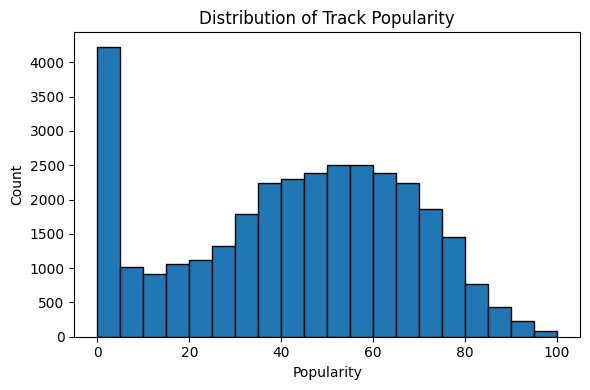

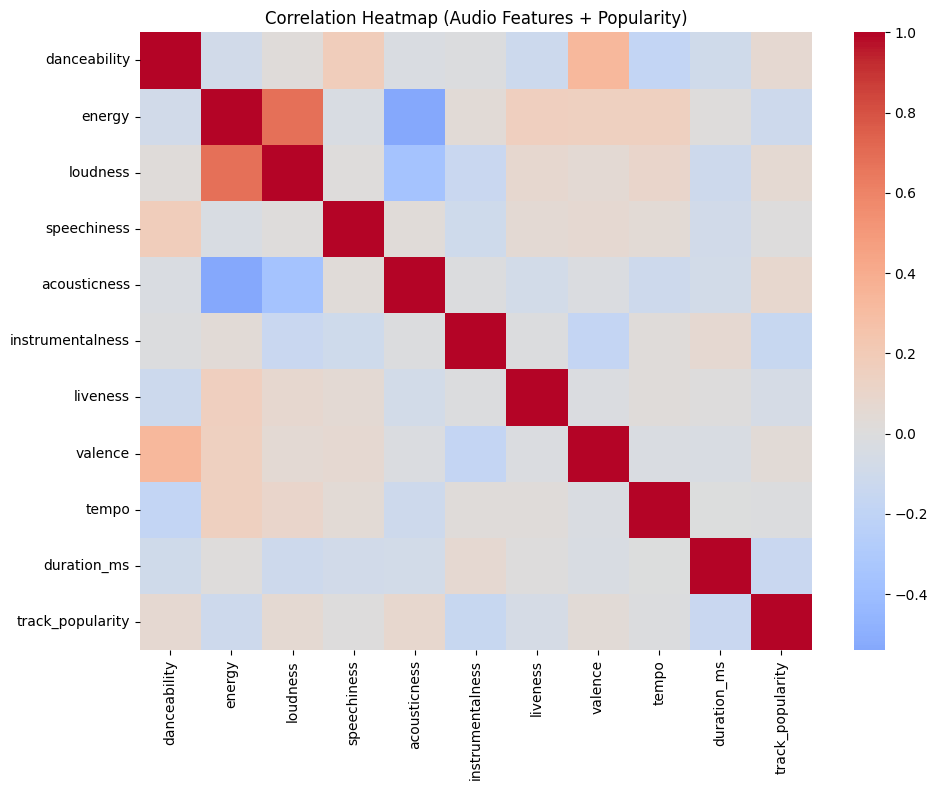

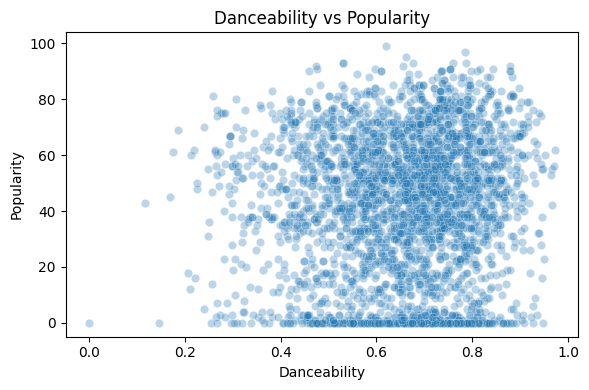

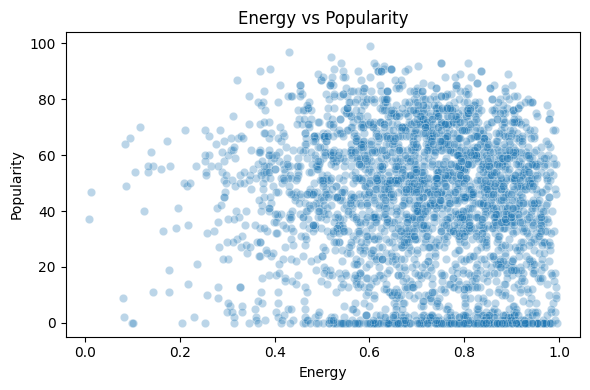

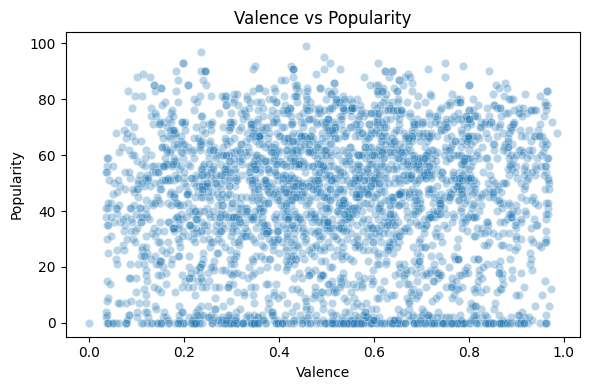

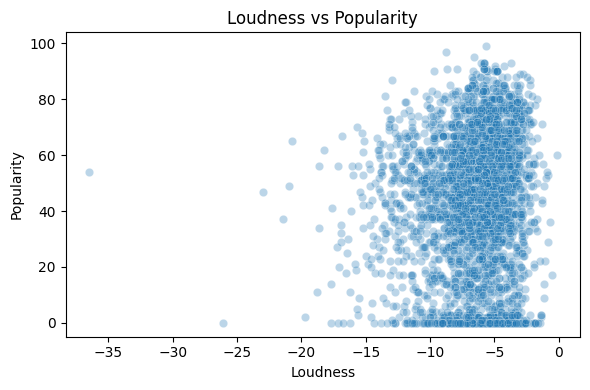


================ HYPOTHESIS TESTING ================

Correlation between danceability and popularity:
  Pearson r = 0.065, p-value = 7.575e-32
  Spearman r = 0.065, p-value = 2.560e-32

Correlation between energy and popularity:
  Pearson r = -0.109, p-value = 1.662e-87
  Spearman r = -0.118, p-value = 5.772e-103

T-test: Popularity of high vs low danceability songs
  Mean popularity (low danceability):  40.87
  Mean popularity (high danceability): 44.86
  t-statistic = 10.211, p-value = 2.085e-24

ANOVA: Popularity across low / medium / high valence groups
  Mean popularity (low valence):    40.50
  Mean popularity (medium valence): 43.37
  Mean popularity (high valence):   42.76
  F-statistic = 35.758, p-value = 3.072e-16

Train set size: (26266, 10)
Test set size : (6567, 10)

===== BASELINE MODEL (Predict Mean Popularity) =====
Baseline MAE  : 20.877
Baseline RMSE : 24.921

===== LINEAR REGRESSION MODEL PERFORMANCE (Test Set) =====
MAE  : 20.080
RMSE : 24.015
R^2  : 0.071

===== 

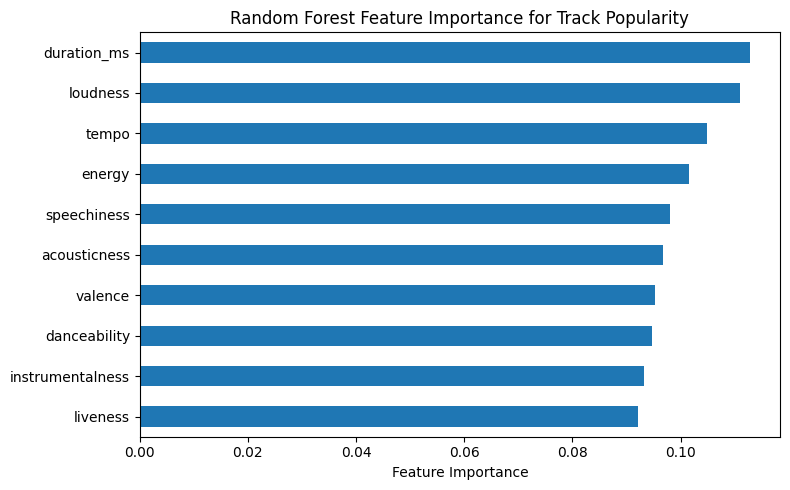


Sample of actual vs predicted popularity (first 20 test songs):
    actual_popularity  predicted_RF  predicted_LR  predicted_GB  \
0                  45     41.153095     40.324176     44.074137   
1                  17     22.276667     32.288399     33.022522   
2                  30     42.775111     46.335376     43.154489   
3                  35     37.566667     40.564769     46.262138   
4                  62     32.717167     28.429182     30.962371   
5                  22     45.190222     45.445736     47.462242   
6                  33     35.753750     43.361299     44.390300   
7                  78     67.044444     46.548441     49.365141   
8                  44     46.138333     44.133704     49.879590   
9                  50     45.872667     49.552231     53.835208   
10                 69     29.206111     41.907522     40.409516   
11                 31     38.383611     52.986832     43.667754   
12                 54     36.540000     -2.515411     42.350630 

In [ ]:
# ==========================================================
# SPOTIFY POPULARITY PROJECT
# - Data exploration & visualization
# - Hypothesis testing
# - Popularity prediction with multiple models
# ==========================================================

# ---------------- 1. IMPORT LIBRARIES ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor  # pip install xgboost if needed

from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway

pd.set_option("display.max_columns", None)

# ---------------- 2. LOAD DATA ----------------
# Make sure the file 'spotify_songs.csv' is in the same directory as this script.
df = pd.read_csv("spotify_songs.csv")

print("Dataset loaded.")
print("Shape (rows, columns):", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# ---------------- 3. BASIC INFO & MISSING VALUES ----------------
print("\nData types and non-null counts:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

# ---------------- 4. BASIC CLEANING ----------------
# 4.1 Drop duplicates
df = df.drop_duplicates()
print("\nShape after dropping duplicates:", df.shape)

# 4.2 Define target column (adjust name if needed)
target_col = "track_popularity"
if target_col not in df.columns:
    raise ValueError(f"Column '{target_col}' not found. Check your CSV column names.")

# Drop rows where popularity is missing
if df[target_col].isnull().sum() > 0:
    df = df.dropna(subset=[target_col])
    print("Dropped rows with missing popularity. New shape:", df.shape)

# ---------------- 5. SELECT AUDIO FEATURES ----------------
audio_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms"
]

# Check which of these exist in the dataset
missing_feats = [col for col in audio_features if col not in df.columns]
if missing_feats:
    print("\nWARNING: These features were not found in the dataset and will be removed from the model:")
    print(missing_feats)
    audio_features = [col for col in audio_features if col in df.columns]

print("\nUsing these feature columns:")
print(audio_features)

# Drop rows with any missing values in selected features or target
df_model = df.dropna(subset=audio_features + [target_col])
print("\nShape after dropping rows with missing features/target:", df_model.shape)

print("\nDescriptive statistics for features + target:")
print(df_model[audio_features + [target_col]].describe())

# ==========================================================
# PART A: DATA VISUALIZATION
# ==========================================================

# ---------- A1. Distribution of Popularity ----------
plt.figure(figsize=(6, 4))
plt.hist(df_model[target_col], bins=20, edgecolor="black")
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ---------- A2. Correlation Heatmap ----------
plt.figure(figsize=(10, 8))
corr = df_model[audio_features + [target_col]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Audio Features + Popularity)")
plt.tight_layout()
plt.show()

# ---------- A3. Scatter Plots: Selected Features vs Popularity ----------
scatter_feats = [f for f in ["danceability", "energy", "valence", "loudness"] if f in audio_features]

for feat in scatter_feats:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=df_model.sample(min(3000, len(df_model)), random_state=42),
        x=feat, y=target_col, alpha=0.3
    )
    plt.title(f"{feat.capitalize()} vs Popularity")
    plt.xlabel(feat.capitalize())
    plt.ylabel("Popularity")
    plt.tight_layout()
    plt.show()

# ==========================================================
# PART B: HYPOTHESIS TESTING
# ==========================================================
# H1: Songs with higher danceability have higher popularity.
# H2: Songs with higher energy have higher popularity.
# H3: Songs with "medium" valence have different popularity than low/high valence.

print("\n================ HYPOTHESIS TESTING ================")

# ---------- B1. Correlation Tests (Danceability & Energy vs Popularity) ----------
for feat in ["danceability", "energy"]:
    if feat in audio_features:
        pearson_r, pearson_p = pearsonr(df_model[feat], df_model[target_col])
        spearman_r, spearman_p = spearmanr(df_model[feat], df_model[target_col])

        print(f"\nCorrelation between {feat} and popularity:")
        print(f"  Pearson r = {pearson_r:.3f}, p-value = {pearson_p:.3e}")
        print(f"  Spearman r = {spearman_r:.3f}, p-value = {spearman_p:.3e}")
    else:
        print(f"\n{feat} not available, skipping correlation test.")

# ---------- B2. T-test: Top 25% vs Bottom 25% Danceability ----------
if "danceability" in audio_features:
    q25 = df_model["danceability"].quantile(0.25)
    q75 = df_model["danceability"].quantile(0.75)

    low_d = df_model[df_model["danceability"] <= q25][target_col]
    high_d = df_model[df_model["danceability"] >= q75][target_col]

    t_stat, p_val = ttest_ind(high_d, low_d, equal_var=False)

    print("\nT-test: Popularity of high vs low danceability songs")
    print(f"  Mean popularity (low danceability):  {low_d.mean():.2f}")
    print(f"  Mean popularity (high danceability): {high_d.mean():.2f}")
    print(f"  t-statistic = {t_stat:.3f}, p-value = {p_val:.3e}")
else:
    print("\nDanceability not available, skipping t-test.")

# ---------- B3. ANOVA: Popularity across low / medium / high valence ----------
if "valence" in audio_features:
    valence_low = df_model[df_model["valence"] < 0.33][target_col]
    valence_mid = df_model[(df_model["valence"] >= 0.33) & (df_model["valence"] <= 0.66)][target_col]
    valence_high = df_model[df_model["valence"] > 0.66][target_col]

    f_stat, p_val = f_oneway(valence_low, valence_mid, valence_high)

    print("\nANOVA: Popularity across low / medium / high valence groups")
    print(f"  Mean popularity (low valence):    {valence_low.mean():.2f}")
    print(f"  Mean popularity (medium valence): {valence_mid.mean():.2f}")
    print(f"  Mean popularity (high valence):   {valence_high.mean():.2f}")
    print(f"  F-statistic = {f_stat:.3f}, p-value = {p_val:.3e}")
else:
    print("\nValence not available, skipping ANOVA test.")

# ==========================================================
# PART C: MODELING – MULTIPLE REGRESSION MODELS
# ==========================================================

# ---------- C1. Train-Test Split ----------
X = df_model[audio_features]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain set size:", X_train.shape)
print("Test set size :", X_test.shape)

# ---------- C2. Baseline Model (Predict Mean Popularity) ----------
baseline_pred = np.full(shape=len(y_test), fill_value=y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

print("\n===== BASELINE MODEL (Predict Mean Popularity) =====")
print(f"Baseline MAE  : {baseline_mae:.3f}")
print(f"Baseline RMSE : {baseline_rmse:.3f}")

# ---------- C3. Linear Regression Model ----------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

lin_mae = mean_absolute_error(y_test, y_pred_lin)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
lin_r2 = r2_score(y_test, y_pred_lin)

print("\n===== LINEAR REGRESSION MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {lin_mae:.3f}")
print(f"RMSE : {lin_rmse:.3f}")
print(f"R^2  : {lin_r2:.3f}")

# ---------- C4. Gradient Boosting Regressor ----------
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

gbr_mae = mean_absolute_error(y_test, y_pred_gbr)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
gbr_r2 = r2_score(y_test, y_pred_gbr)

print("\n===== GRADIENT BOOSTING MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {gbr_mae:.3f}")
print(f"RMSE : {gbr_rmse:.3f}")
print(f"R^2  : {gbr_r2:.3f}")

# ---------- C5. XGBoost Regressor ----------
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print("\n===== XGBOOST MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {xgb_mae:.3f}")
print(f"RMSE : {xgb_rmse:.3f}")
print(f"R^2  : {xgb_r2:.3f}")

# ---------- C6. SVM Regressor (SVR with RBF kernel) ----------
# SVR is sensitive to scaling, so we use a Pipeline with StandardScaler.
# It can also be slow on very large datasets, so we optionally downsample the training set.

max_svm_train = 10000  # adjust if needed for speed
if len(X_train) > max_svm_train:
    svm_sample = X_train.sample(max_svm_train, random_state=42)
    svm_idx = svm_sample.index
    X_train_svm = svm_sample
    y_train_svm = y_train.loc[svm_idx]
else:
    X_train_svm = X_train
    y_train_svm = y_train

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.2))
])

svm_model.fit(X_train_svm, y_train_svm)
y_pred_svm = svm_model.predict(X_test)

svm_mae = mean_absolute_error(y_test, y_pred_svm)
svm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
svm_r2 = r2_score(y_test, y_pred_svm)

print("\n===== SVM (SVR-RBF) MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {svm_mae:.3f}")
print(f"RMSE : {svm_rmse:.3f}")
print(f"R^2  : {svm_r2:.3f}")

# ---------- C7. Random Forest Regressor ----------
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

print("\n===== RANDOM FOREST MODEL PERFORMANCE (Test Set) =====")
print(f"MAE  : {rf_mae:.3f}")
print(f"RMSE : {rf_rmse:.3f}")
print(f"R^2  : {rf_r2:.3f}")

# ---------- C8. Model Comparison Summary ----------
print("\n===== MODEL COMPARISON SUMMARY (Test Set) =====")
print(f"{'Model':<25}{'MAE':>10}{'RMSE':>10}{'R^2':>10}")
print("-" * 55)
print(f"{'Baseline (Mean)':<25}{baseline_mae:>10.3f}{baseline_rmse:>10.3f}{'--':>10}")
print(f"{'Linear Regression':<25}{lin_mae:>10.3f}{lin_rmse:>10.3f}{lin_r2:>10.3f}")
print(f"{'Gradient Boosting':<25}{gbr_mae:>10.3f}{gbr_rmse:>10.3f}{gbr_r2:>10.3f}")
print(f"{'XGBoost':<25}{xgb_mae:>10.3f}{xgb_rmse:>10.3f}{xgb_r2:>10.3f}")
print(f"{'SVR (RBF)':<25}{svm_mae:>10.3f}{svm_rmse:>10.3f}{svm_r2:>10.3f}")
print(f"{'Random Forest':<25}{rf_mae:>10.3f}{rf_rmse:>10.3f}{rf_r2:>10.3f}")

# ---------- C9. Feature Importance (Random Forest) ----------
importances = rf_model.feature_importances_
feat_imp_series = pd.Series(importances, index=audio_features).sort_values(ascending=True)

print("\nFeature importances (higher = more important) [Random Forest]:")
print(feat_imp_series.sort_values(ascending=False))

plt.figure(figsize=(8, 5))
feat_imp_series.plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance for Track Popularity")
plt.tight_layout()
plt.show()

# ---------- C10. Sample Predictions ----------
results_sample = pd.DataFrame({
    "actual_popularity": y_test.values[:20],
    "predicted_RF": y_pred_rf[:20],
    "predicted_LR": y_pred_lin[:20],
    "predicted_GB": y_pred_gbr[:20],
    "predicted_XGB": y_pred_xgb[:20],
    "predicted_SVM": y_pred_svm[:20]
})

print("\nSample of actual vs predicted popularity (first 20 test songs):")
print(results_sample)

# ==========================================================
# END OF SCRIPT
# ==========================================================
